# Feature selection
 
Now we discuss the **feature selection** approach to dimensionality reduction. Feature selection approaches lower the dimensionality by picking a subset of original features. Typically, feature selection is done to facilitate predictions of a target variable in the context of supervised learning. The prediction problem we consider here is a two-class classification: given a gene expression profile, can we predict to which of the two tomato species it belongs? We will do a six-fold cross-validation of the prediction approach, keeping 4 data instances for testing while training on the other 20 instances. More specifically, we will do a leave-one-tissue-out cross-validation, training on the samples from five tissues and testing on the samples from the sixth tissue. In this way, we can evaluate whether the classification model based on selected features generalizes to unseen tissues. In total, we obtain six different models from this tissue-wise cross-validation.

We will consider examples for three types of feature selection approaches:
1. Filter methods
2. Wrapper methods
3. Embedded methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ReliefF import ReliefF
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1).to_numpy()
target = data_with_labels['species'].to_numpy()

## Filter methods 
Filter methods compute a score for each individual feature and rank the features according to the score. Then a prespecified number of top features is selected, or one takes all features that satisfy a prespecified threshold. Most filter methods are univariate and perform some statistical test with respect to the target variable. We will consider a multivariate filter method that uses k nearest neighbor computation across all the features to compute the score of an individual feature. The method is called ReliefF. Each feature obtains a score based on value differences between nearest neighbors. A value difference in nearest neighbors of the same class decreases the score, and a value difference in nearest neighbors of different classes increases the score. We determine the highest scoring feature on the training set and use it in a simple decision tree classifier.

Selected gene: 18967


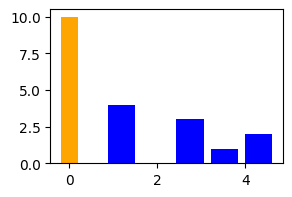

Test accuracy: 1.0
Selected gene: 20995


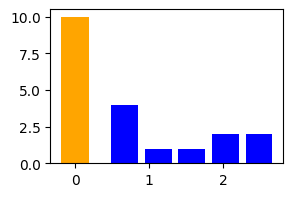

Test accuracy: 1.0
Selected gene: 26093


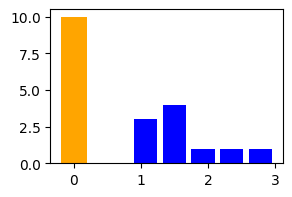

Test accuracy: 1.0
Selected gene: 11057


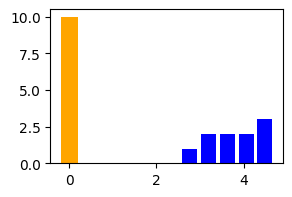

Test accuracy: 1.0
Selected gene: 6261


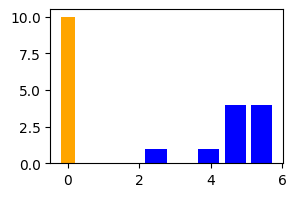

Test accuracy: 1.0
Selected gene: 11499


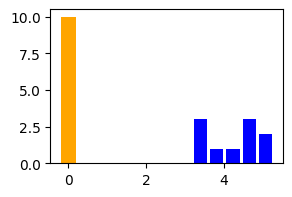

Test accuracy: 1.0


In [16]:
for tissue in data_with_labels['tissue'].unique():
    wtest = np.where(data_with_labels['tissue']==tissue)[0]
    wtrain = np.setdiff1d(range(data_with_labels.shape[0]), wtest)
    fs = ReliefF(n_neighbors=4, n_features_to_keep=1)
    X = fs.fit_transform(data_original[wtrain,:], target[wtrain])
    w = np.where(data_with_labels['species'].iloc[wtrain]=='M82')
    print(f"Selected gene: {fs.top_features[0]}")
    plt.rcParams["figure.figsize"] = (3,2) 
    plt.hist(X[w,0], bins=5, density=False, histtype='barstacked', rwidth=0.8, facecolor='blue')
    plt.hist(np.delete(X[:,0], w), bins=1, density=False, histtype='barstacked', rwidth=0.38, facecolor='orange')
    plt.show()
    classifier = tree.DecisionTreeClassifier()
    cl = classifier.fit(X, target[wtrain])
    accuracy = accuracy_score(target[wtest], cl.predict(data_original[wtest, fs.top_features[0]].reshape(-1, 1)))
    print(f"Test accuracy: {accuracy}")

In each cross-validation iteration, a different gene got selected as the top feature, but the gene-based species classification always generalized well to the unseen tissue, as reflected by the perfect accuracy.

## Wrapper methods

Wrapper methods do not depend on the machine learning approach used for modeling. In other words, the same wrapper can be used for many different machine learning approaches. They perform a search through possible sets of features. For each considered combination of features, a model is trained and evaluated on a validation set. The evaluation scores are used to select the best among candidate sets. Forward selection is a greedy procedure starting with an empty feature set and adding in each step the feature leading to the set with the best performance on validation data. To have validation data that are independent from the data used for training the model, typically a nested cross-validation on the training data is performed, just like for the hyperparameter optimization in general machine learning approaches. The test set is reserved for final evaluation of the model with selected features and is not touched during the feature selection. The following graphic illustrates the analysis that is done for a single step in the forward selection.

<center><img src="./figures/wrapper.png" width="500"/></center>


We will try the forward selection approach on the tomato dataset. For illustration purposes, we will use a simple decision tree model with low computational costs. To further reduce the runtime, we only use the first 500 genes as candidates.

In [56]:
max_nr_features = 3
for tissue in data_with_labels['tissue'].unique():
    wtest = np.where(data_with_labels['tissue']==tissue)[0]
    # forward selection using inner cross-validation
    print(f"Test tissue: {tissue}")
    tissue_types_train = np.setdiff1d(data_with_labels['tissue'].unique(), tissue)
    available_features = range(500) # range(data_original.shape[1])
    selected_features =  np.empty(0, dtype=np.int8)
    for f in range(max_nr_features):
        available_features = np.setdiff1d(available_features, selected_features)
        performances = np.zeros((len(tissue_types_train), len(available_features)))
        for i in range(len(tissue_types_train)):
            wval = np.where(data_with_labels['tissue']==tissue_types_train[i])[0]
            wtrain = np.setdiff1d(range(data_with_labels.shape[0]), np.append(wval, wtest))
            for n in range(len(available_features)):
                classifier = tree.DecisionTreeClassifier()
                candidate_set = np.append(selected_features, available_features[n])
                cl = classifier.fit(data_original[np.ix_(wtrain, candidate_set)], target[wtrain])
                performances[i,n] = accuracy_score(target[wval], cl.predict(data_original[np.ix_(wval, candidate_set)]))
        kfold_performance = np.apply_along_axis(np.mean, 0, performances)
        selected_features = np.append(selected_features, available_features[np.argmax(kfold_performance)])
    print(selected_features)
    # retrain model with selected features on whole training data and test performance
    classifier_final = tree.DecisionTreeClassifier()
    wtrain_outer = np.setdiff1d(range(data_with_labels.shape[0]), wtest)
    clf = classifier_final.fit(data_original[np.ix_(wtrain_outer, selected_features)], target[wtrain_outer])
    accuracy = accuracy_score(target[wtest], clf.predict(data_original[np.ix_(wtest, selected_features)]))
    print(f"Test accuracy: {accuracy}")    

Test tissue: floral
[138   0   1]
Test accuracy: 1.0
Test tissue: leaf
[138   0   1]
Test accuracy: 1.0
Test tissue: root
[123   0   1]
Test accuracy: 0.5
Test tissue: sdling
[138   0   1]
Test accuracy: 1.0
Test tissue: stem
[138   0   1]
Test accuracy: 1.0
Test tissue: veg
[138   0   1]
Test accuracy: 1.0


Note that in the case where there are several top feature candidates with equivalent performance, we make the arbitrary choice of selecting the one with the smallest index. The top three selected features strongly overlap between the different forward selection runs from the outer cross-validation. They are always the same except when root is the test tissue, in which case also the test accuracy drops. This indicates that the model with the selected feature 123 does not generalize from the other tissues to the root tissue. When the root tissue was contained in the training data, the model always generalized to unseen tissues.

Alternatively to setting a number of features to select, one can stop if the performance does not improve anymore. This is often done in practice, but keep in mind that you might overfit to your validation set, so having an independent test set is crucial. Also, decision trees are generally prone to overfitting and have low classification performance in complex classification problems. Therefore, random forest models should be preferred in most real-case scenarios, in particular if the model needs to combine several predictor variables for accurate classification.


### Task
1. Backward elimination is another wrapper approach. It starts from all features and progressively eliminates the least promising ones. Please consider advantages and disadvantages of this approach.
2. How can you adjust the approach to alleviate the disadvantages?

## Embedded methods 

Embedded methods learn which features are important while the model is built. These methods use regularization to drive the optimization toward models of lower complexity. As an example method from this category, we will apply elastic net regression, which is very useful in practice for high-dimensional data. It is a linear modeling approach where the objective function contains a combination of L1 and L2 regularization. The L1 regularization favors sparse solutions, setting many coefficients to zero and thus performing feature selection. The L2 regularization shrinks the coefficients of correlated predictors towards each other, such that either all correlated features are selected or none of them. We again perform cross-validation via a tissue-wise split. We set the L1-L2 tradeoff parameter to 0.5 and the regularization parameter to 0.1. Since the model is linear, we can easily distinguish positive predictors, where increased expression increases the probability of being classified as class 1, and negative predictors, where decreased expression increases the probability of being classified as class 1.

In [41]:
tissue_types = data_with_labels['tissue'].unique()
num_selected_pos = np.zeros(len(tissue_types))
num_selected_neg = np.zeros(len(tissue_types))
for i in range(len(tissue_types)):
    wtest = np.where(data_with_labels['tissue']==tissue_types[i])[0]
    wtrain = np.setdiff1d(range(data_with_labels.shape[0]), wtest)
    scaler = StandardScaler().set_output(transform="default")
    data_train = scaler.fit_transform(data_original[wtrain,:])
    logistic = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5, C=0.1, max_iter=5000, random_state=42)
    logistic.fit(data_train, target[wtrain])
    selected_curr_pos = np.where(logistic.coef_.reshape(-1, 1)>0)[0]
    selected_curr_neg = np.where(logistic.coef_.reshape(-1, 1)<0)[0]
    if (i==0): 
        selected_all_pos = selected_curr_pos
        selected_all_neg = selected_curr_neg
    else:
        selected_all_pos = np.intersect1d(selected_all_pos, selected_curr_pos) 
        selected_all_neg = np.intersect1d(selected_all_neg, selected_curr_neg)           
    num_selected_pos[i] = len(selected_curr_pos)
    num_selected_neg[i] = len(selected_curr_neg)
    data_test = scaler.transform(data_original[wtest,:]) # transform with scaling parameters determined on training data
    pred = logistic.predict(data_test)
    print(pred)
    print(target[wtest])
    accuracy = accuracy_score(target[wtest], pred)
    print(f"Test accuracy: {accuracy}")


['penn' 'penn' 'M82' 'M82']
['penn' 'penn' 'M82' 'M82']
Test accuracy: 1.0
['penn' 'penn' 'M82' 'M82']
['penn' 'penn' 'M82' 'M82']
Test accuracy: 1.0
['penn' 'penn' 'M82' 'M82']
['penn' 'penn' 'M82' 'M82']
Test accuracy: 1.0
['penn' 'penn' 'M82' 'M82']
['penn' 'penn' 'M82' 'M82']
Test accuracy: 1.0
['penn' 'penn' 'M82' 'M82']
['penn' 'penn' 'M82' 'M82']
Test accuracy: 1.0
['penn' 'penn' 'M82' 'M82']
['penn' 'penn' 'M82' 'M82']
Test accuracy: 1.0


The test accuracy looks promising. However, how robust is the gene selection across models? Are there common positive and negative predictors between all six models from the cross-validation? To answer that question, we show the number of selected genes for each model from the cross-validation as well as the number of genes that were selected in all models (i.e., the overall intersection, indicated by the horizontal line). We consider positive and negative predictors separately to make sure that signs are consistent across models.

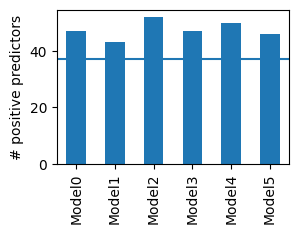

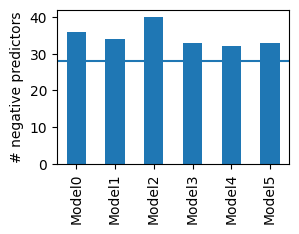

In [42]:
num_selected_pos_df = pd.DataFrame(num_selected_pos, index=[f"Model{i}" for i in range(len(num_selected_pos))])
num_selected_neg_df = pd.DataFrame(num_selected_neg, index=[f"Model{i}" for i in range(len(num_selected_neg))])
num_selected_pos_df.plot.bar(ylabel='# positive predictors', legend = False).axhline(y=len(selected_all_pos))
num_selected_neg_df.plot.bar(ylabel='# negative predictors', legend = False).axhline(y=len(selected_all_neg))

### Task
1. Now that you got a glimpse into filter, wrapper and embedded methods, compare and discuss their applicability in practice.
2. Instead of predicting the species, let us consider the scenario of predicting the tissue type from a gene expression profile. How would you proceed? HOw would you change the above setup?